In [2]:
# load required R packages
# 载入需要的R包
library(tidyverse)
library(DESeq2)
library(BioSeqUtils)
library(caret)
library(randomForest)
library(ROCR) 
library(pROC)
library(ggplot2)
library(PRROC)
library(tidymodels)
library(Seurat)
library(patchwork)
library(ggsci)
library(ada)
library(plotrix)
library(kernlab)
library(precrec)

In [3]:
#setting working directory
# 设置工作路径
setwd("D:\\project\\白骨壤Cd")

In [4]:
theme_cleveland <- function (rotate = TRUE) 
{
    if (rotate) {
        theme(panel.grid.major.x = element_blank(), panel.grid.minor.x = element_blank(), 
            panel.grid.major.y = element_line(colour = "grey70", 
                linetype = "dashed"))
    }
}

In [5]:
# model evaluation metrics
# 模型评估指标
metrics2 <- function(Pred,realY){
  AUC_ROC <- roc(realY,Pred)
  AUC_ROC <- AUC_ROC$auc
  pred.class <- as.integer(Pred > 0.5)
  TBL <- table(pred.class, realY)
  TP <- TBL[2,2]
  FP <- TBL[2,1]                  
  TN <- TBL[1,1]                                                                     
  FN <- TBL[1,2]
  Specificity <- TN/(TN+FP)
  Sensitivity <- TP/(TP+FN)
  Precision <- TP/(TP+FP)
  Recall <- TP/(TP+FN)
  F1 <- 2 * (Precision*Recall/(Precision+Recall))
  MCC <- (TP*TN-FP*FN)/sqrt((TP+FP)*(TP+FN))/sqrt((TN+FP)*(TN+FN))
  Accuracy <- (TP+TN)/(TP+TN+FP+FN)
  tmp <- data.frame(V1=realY, V2=Pred)
  tmp$V1 <- factor(tmp$V1)
  tmp <- evalmod(scores = tmp$V2, labels = tmp$V1)
  aucs <- auc(tmp)
  AUC_PRC <- subset(aucs, curvetypes == "PRC")
  AUC_PRC <- AUC_PRC$aucs
  re <- data.frame(Sensitivity,Specificity,Precision,Recall,Accuracy,AUC_ROC,AUC_PRC,MCC,F1)
  return(re)
}

In [6]:
# custom function for differentially expressed genes analysis using DESeq2 R package
# 构建函数，使用DESeq2进行差异表达分析
DEG <- function(count,sampleNames,comparison,rep=3){
    data <- count[,sampleNames]
    countData <- as.matrix(data)
    condition <- c(rep("control",rep),rep("treatment",rep))
    database <- data.frame(name=sampleNames, condition=condition)
    database$condition <- factor(database$condition)
    rownames(database) <- sampleNames
    dds <- DESeqDataSetFromMatrix(countData, colData=database, design= ~ condition)
    dds <- dds[ rowSums(counts(dds)) > 10, ]
    dds <- DESeq(dds)
    res <- results(dds,contrast=c("condition", "treatment", "control"))
    res <- res %>%
        as.data.frame() %>%
        mutate(comparison=comparison,gene=rownames(res))
    return(res)
}

In [7]:
# custom function for reading gene expression in raw counts format
# 读取基因表达数据(格式raw counts)
read_count <- function(path="03_raw_counts/",file="Avicennia_marina.counts"){
    Count <- read.table(paste0(path,file),head=T,check.names = F,row.names=1)
    Count <- Count %>%
        dplyr::select(-c(Chr,Start,End,Strand,Length))
        Cols <- lapply(colnames(Count),function(x){
            unlist(str_split(x,'[-.]'))[3]
        }) 
    colnames(Count) <- unlist(Cols)
    return(Count)
}

In [8]:
# custom function for reading gene expression in FPKM format
# 读取基因表达数据(格式FPKM)
read_fpkm <- function(path="04_TPM_FPKM/",file="Athaliana.fpkm"){
    fpkm <- read.table(paste0(path,file),head=T,check.names = F,row.names=1)
        Cols <- lapply(colnames(fpkm),function(x){
            unlist(str_split(x,'[-.]'))[3]
        }) 
    colnames(fpkm) <- unlist(Cols)
    return(fpkm)
}

In [9]:
Count <- read_count(path="03_raw_counts/",file="Avicennia_marina.counts")
fpkm <- read_fpkm(path="04_TPM_FPKM//",file="Avicennia_marina.fpkm")

In [10]:
fpkm <- fpkm[,c("Con_2","Con_3","Con_4","Cd_1",'Cd_2','Cd_4')]

In [11]:
fpkm <- data.frame(gene=rownames(fpkm),avg_fpkm=apply(fpkm,1,mean))

In [12]:
Am_deg <- DEG(count=Count,
    sampleNames= c("Con_2","Con_3","Con_4","Cd_1",'Cd_2','Cd_4'),
    comparison=c("Cd"),
          rep=3)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [13]:
Am_deg <- Am_deg[!is.na(Am_deg$padj),]

In [14]:
# loading genomics sequence features
# 读取基因特征矩阵
Am <- read.csv("期刊/JHM/revise/Avicennia_marina_feature.csv")
colnames(Am)[1] <- 'gene'

In [15]:
Am2 <- Am %>%
    dplyr::filter(gene %in% Am_deg$gene)

In [16]:
Am_DEG <- Am_deg
Am_DEG <- Am_DEG %>%
    mutate(Organism = "Avicennia marina") %>%
    dplyr::filter(gene %in% Am2$gene)

In [17]:
rownames(Am2) <- Am2$gene
Am2 <- Am2[,-1]
Am2 <- data.frame(t(Am2))
objs <- CreateSeuratObject(counts = Am2, project = "all", meta=Am_deg,min.cells = 1, min.features = 1)
objs <- NormalizeData(objs, normalization.method = "LogNormalize", scale.factor = 30)
objs <- FindVariableFeatures(objs, selection.method = "vst", nfeatures = 3000)
all.genes <- rownames(objs)
objs <- ScaleData(objs, features = all.genes)
objs <- RunPCA(objs,npcs =10, features = VariableFeatures(object = objs))
objs <- FindNeighbors(objs, dims = 1:10)
objs <- FindClusters(objs, resolution = 1)
objs <- RunUMAP(objs, dims = 1:10)

Warning message:
"Data is of class data.frame. Coercing to dgCMatrix."
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

PC_ 1 
Positive:  T.Intron, G.Intron, A.Intron, C.Intron, TT.Intron, AT.Intron, TG.Intron, CT.Intron, GT.Intron, GA.Intron 
	   AG.Intron, TA.Intron, TC.Intron, CA.Intron, AA.Intron, AC.Intron, GC.Intron, GG.Intron, CC.Intron, CG.Intron 
	   TA.CDS, AT.CDS, AA.CDS, GG.5UTR, TT.CDS, CC.3UTR, CG.5UTR, TG.CDS, GC.3UTR, CG.Down 
Negative:  G.CDS, C.CDS, T.3UTR, GC.CDS, CG.CDS, GG.CDS, A.Down, T.Up, CC.CDS, T.Down 
	   A.3UTR, TC.CDS, A.Up, GT.Down, AC.Up, C.5UTR, C.Up, CA.Up, TG.Down, GT.Up 
	   CA.5UTR, TT.3UTR, TC.Up, G.Up, G.Down, AT.3UTR, TG.Up, GA.Down, AC.Down, A.5UTR 
PC_ 2 
Positive:  GC.Down, C.Down, CC.Down, G.Down, GG.Down, GC.Up, GG.Up, G.Up, CT.Down, AG.Down 
	   CA.Down, TC.Down, CC.Up, C.Up, CG.Down, GA.Down, C.3UTR, CT.Up, CG.Up, TG.Up 
	   G.5UTR, AG.Up, AC.Down, GA.Up, GC.3UTR, TG.5UTR, TC.Up, GG.5

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25527
Number of edges: 650309

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7283
Number of communities: 11
Elapsed time: 5 seconds


Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
14:58:50 UMAP embedding parameters a = 0.9922 b = 1.112

14:58:50 Read 25527 rows and found 10 numeric columns

14:58:50 Using Annoy for neighbor search, n_neighbors = 30

14:58:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:58:53 Writing NN index file to temp file C:\Users\jasonxu\AppData\Local\Temp\Rtmpu2o3YY\file884843e7367b

14:58:53 Searching Annoy index using 1 thread, search_k = 3000

14:59:02 Annoy recall = 100%

14:59:02 Commencing smooth kNN distance calibration using 1 t

In [18]:
Results <- NULL
evaluation <- NULL
for(ML in c('rf','rpart','ada','lda','knn','glm','svmRadial','naive_bayes','xgbTree','treebag')){
    print(ML)
    roclist <- NULL
    for(type in c('clustering')){
        AUC <- c()
        for(lfc in c(0.5,1,1.5,2)){
            f <- paste0("model/",ML,"/",type,"_log2FC_",lfc,".RData")
            print(f)
            load(f)
            data <- rbind(train,test)
            if(ML %in% c("svmRadial")){
                rf_pred <- predict(model,test)
                rf_pred <- as.numeric(rf_pred)-1
            }else{
                rf_pred <- predict(model,test,type="prob")
                rf_pred <- rf_pred[,2]
            }
            RE <- metrics2(rf_pred,test$class)
            RE$model <- ML
            RE$log2FC <- lfc
            evaluation <- rbind(evaluation,RE)
            predob <- prediction(rf_pred, test$class)
            perf <- performance(predob, 'tpr','fpr')
            perf.auc<- performance(predob, measure = 'auc', x.measure = 'cutoff')
            re_auc <- data.frame(Model=ML,FC=lfc,`AUC-ROC`=unlist(perf.auc@y.values))
            Auc <- paste0("AUC-ROC: ",sprintf("%.3f",unlist(perf.auc@y.values)))
            print(Auc)
            Results <- rbind(Results,re_auc)
            AUC <- c(AUC,Auc)
            re <- data.frame(x = attributes(perf)$x.values[[1]],
                             y = attributes(perf)$y.values[[1]],
                            type = str_to_title(type),
                            lfc)
            roclist <- rbind(roclist,re)
        }
        AUC <- paste(AUC,collapse = '\n')
    }    
}

[1] "rf"
[1] "model/rf/clustering_log2FC_0.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.851"
[1] "model/rf/clustering_log2FC_1.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.971"
[1] "model/rf/clustering_log2FC_1.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.989"
[1] "model/rf/clustering_log2FC_2.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.968"
[1] "rpart"
[1] "model/rpart/clustering_log2FC_0.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.718"
[1] "model/rpart/clustering_log2FC_1.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.867"
[1] "model/rpart/clustering_log2FC_1.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.873"
[1] "model/rpart/clustering_log2FC_2.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.861"
[1] "ada"
[1] "model/ada/clustering_log2FC_0.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.825"
[1] "model/ada/clustering_log2FC_1.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.967"
[1] "model/ada/clustering_log2FC_1.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.993"
[1] "model/ada/clustering_log2FC_2.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.971"
[1] "lda"
[1] "model/lda/clustering_log2FC_0.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.805"
[1] "model/lda/clustering_log2FC_1.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.961"
[1] "model/lda/clustering_log2FC_1.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.978"
[1] "model/lda/clustering_log2FC_2.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.957"
[1] "knn"
[1] "model/knn/clustering_log2FC_0.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.832"
[1] "model/knn/clustering_log2FC_1.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.954"
[1] "model/knn/clustering_log2FC_1.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.969"
[1] "model/knn/clustering_log2FC_2.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.955"
[1] "glm"
[1] "model/glm/clustering_log2FC_0.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.805"
[1] "model/glm/clustering_log2FC_1.RData"


Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.964"
[1] "model/glm/clustering_log2FC_1.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.975"
[1] "model/glm/clustering_log2FC_2.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.891"
[1] "svmRadial"
[1] "model/svmRadial/clustering_log2FC_0.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.795"
[1] "model/svmRadial/clustering_log2FC_1.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.942"
[1] "model/svmRadial/clustering_log2FC_1.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.966"
[1] "model/svmRadial/clustering_log2FC_2.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.950"
[1] "naive_bayes"
[1] "model/naive_bayes/clustering_log2FC_0.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.804"
[1] "model/naive_bayes/clustering_log2FC_1.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.962"
[1] "model/naive_bayes/clustering_log2FC_1.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.982"
[1] "model/naive_bayes/clustering_log2FC_2.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.978"
[1] "xgbTree"
[1] "model/xgbTree/clustering_log2FC_0.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.836"
[1] "model/xgbTree/clustering_log2FC_1.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.966"
[1] "model/xgbTree/clustering_log2FC_1.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.992"
[1] "model/xgbTree/clustering_log2FC_2.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.972"
[1] "treebag"
[1] "model/treebag/clustering_log2FC_0.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.833"
[1] "model/treebag/clustering_log2FC_1.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.965"
[1] "model/treebag/clustering_log2FC_1.5.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.983"
[1] "model/treebag/clustering_log2FC_2.RData"


Setting levels: control = NRG, case = RG

Setting direction: controls < cases



[1] "AUC-ROC: 0.966"


## Figure2C

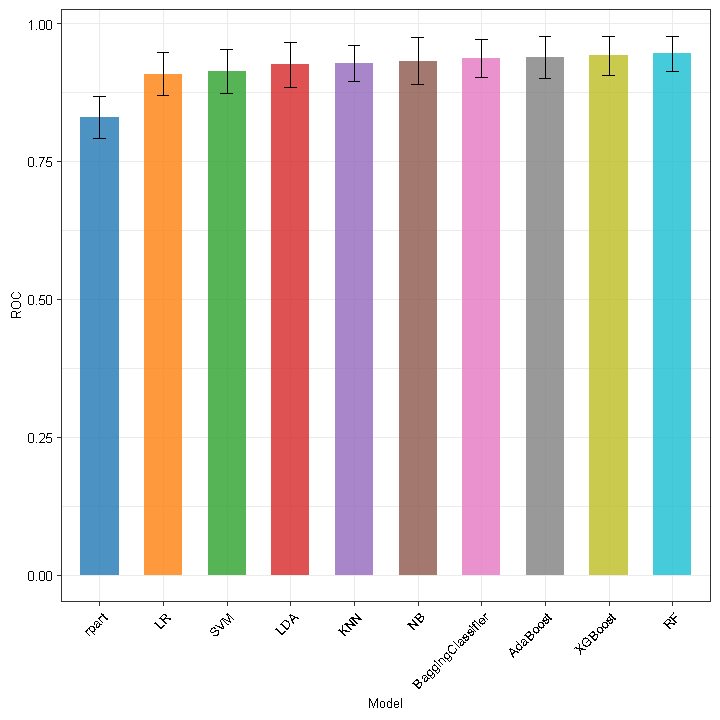

In [19]:
options(repr.plot.width=6, repr.plot.height=6)
Figure2C <- Results %>%
    group_by(Model) %>%
    summarise(ROC=mean(AUC.ROC),se=std.error(AUC.ROC)) %>%
    arrange(ROC) %>%
    mutate(Model=factor(Model,levels=c('rpart','glm','svmRadial','lda','knn','naive_bayes','treebag','ada','xgbTree','rf'))) %>%
    mutate(Model=factor(Model,labels=c('rpart','LR','SVM','LDA','KNN','NB','BaggingClassifier','AdaBoost','XGBoost','RF'))) %>%
    ggplot(aes(Model,ROC,fill=Model))+
                geom_bar(stat='identity',width=0.6,alpha=0.8)+
                geom_errorbar(aes(ymin = ROC - se, ymax = ROC + se),position = position_dodge(0.9), width = .2)+
                theme_bw()+
                theme(axis.text = element_text(size=8,color='black'),
                      axis.text.x = element_text(size=8,color='black',angle=45,hjust=1),
                      axis.title=element_text(size=8,color='black'),
                     legend.position='none',
                     strip.text = element_text(size = 8, colour = "black"))+
scale_fill_d3()
Figure2C